### Plotting winds, ice speed from nextSIM and OSISAF and Arcleads along transect 

**Plotting WRF10 and WRF80**

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2022
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [9]:
# allow plots to be interactive in the notebook
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
import matplotlib.ticker as mticker
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

In [10]:
def get_transect(xr, start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)
    
    return ydist, vtimes, transect

def get_transect_osisaf(arr, xpoint, ypoint):
    '''
    Parameters:
            arr : np.dataarray  
            xpoint: (list) x-coordinate for transect
            ypoint: (list) y-coordinate for transect
    '''

    transect = arr[ypoint[0]:ypoint[1], xpoint, :]

    # Specify y values for transect
    length = ypoint[1] - ypoint[0]
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)
    
    print(ydist.shape, transect.shape)

    return ydist, transect


def plot_map(ax):

    lons = ds.longitude[:] #dims:y,x
    lats = ds.latitude[:]

    # find lon,lat coordinates for x,y points
    lon0 = lons[ypoint[0]][xpoint[0]]
    lon1 = lons[ypoint[1]][xpoint[1]]
    lat0 = lats[ypoint[0]][xpoint[0]]
    lat1 = lats[ypoint[1]][xpoint[1]]
    lon = (lon0, lon1)
    lat = (lat0, lat1)
    
    proj = ccrs.NorthPolarStereo(central_longitude=-45)
    ax.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], crs=ax.projection) 

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="lightgrey") 
    ax.coastlines(resolution='50m', linewidth=0.5) 
    ax.gridlines(draw_labels=False, linestyle='--', alpha=0.5,  linewidth=0.3)
    ax.plot(lon, lat, 'ro-',linewidth=1, markersize=3, transform=ccrs.Geodetic()) # geodetic plots shortest distance 
#    ax.patch.set_alpha(0.7)

def plot_transect(ax, vname, add_insetmap=True):
    global clabel, figname, cmap, clim, cb_extend, zlev
    clabel, figname, cmap, clim, cb_extend, zlev = _PLOT_INFO[vname]
    
    print("Start plotting", vname)
    
    if np.size(clim)==2: #contineous colormap 
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
        vmin=clim[0], vmax=clim[1], cmap=cmap, extend=cb_extend)
    else: #discrete colormap
        clevs = np.arange(clim[0], clim[1]+clim[2],clim[2])
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
            levels=clevs, cmap=cmap, extend=cb_extend)

    # add single contour line
    cline = ax.contour(vtimes, yvals, transect.transpose(), levels=zlev,  colors='k', linewidths=1)
    
    # add colorbar
    pos = ax.get_position() 
    cax = fig.add_axes([pos.xmax+.015, pos.y0, 0.01, pos.ymax-pos.y0 ])
    cbar=fig.colorbar(cf,cax=cax)
    cbar.set_label(clabel)
    ticks = clevs[::5]
    cbar.set_ticks(ticks)
    
    # set labels
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    ax.xaxis.set_major_formatter(dtFmt)
    ax.xaxis.set_minor_locator(days)

    # add map 
    if add_insetmap:
        proj = ccrs.NorthPolarStereo(central_longitude=-45)
        ax_inset = inset_axes(ax, height='50%', width='50%',
                              loc=3, bbox_to_anchor=(0,0,0.3,1), bbox_transform=ax.transAxes,
                              axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                              axes_kwargs=dict(map_projection=proj))
        plot_map(ax_inset) 
        
def plot_vectors(ax, ds):
    
    time = ds['time']
    u = ds['wndx']
    v = ds['wndy']

    # calculate the magnitude
    scale=2
    magnitude = (u**2 + v**2)**0.5
    maxmag = max(magnitude)/scale
    ax.set_ylim(-maxmag, maxmag)
    xint = 2 # set interval
    q = ax.quiver(time[::xint], 0, u[::xint],v[::xint],  
           color='r',
           units='y',
           scale_units='y',
           scale = 2,
           headlength=2,
           headaxislength=2,
           width=0.2,
           alpha=1
              )

    qk = plt.quiverkey(q,0.17, 0.2, 10,
               r' 10 m s$^{-1}$',
               labelpos='W',
               fontproperties={'weight': 'normal'})

    # Fake 'box' to be able to insert a legend'
#    p = ax.add_patch(plt.Rectangle((1,1),1,1,fc='w',alpha=1))
#    leg1 = ax.legend([p], ["[x, y]=" + "["+str(xloc)+", "+str(yloc)+"]"],loc='lower right')
#    leg1._drawFrame=False

    # add horizontal line at y=0
    ax.axhline(linewidth=1, color='grey', alpha=0.2)

    ax.set_xlim(min(time),max(time))
    ax.set_yticklabels([])


In [12]:
# main

# create dictionary for plotting different variables
_PLOT_INFO =dict(
    wspeed = ('Wind speed (m s$^{-1}$)', 'wspeed_transect_beaufort','RdYlBu_r', [0,20,1], 'max', [10]),
    icevel = ('Ice velocity (cm s$^{-1}$)', 'icevel_transect_beaufort', cmocean.cm.speed, [0, 40, 2], 'max', [5]),    
)


rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

expts = ["expt_01_wrf10/outputs/", "expt_04_wrf80/outputs/"]
expts_names = "wrf10"

# Create slice variables subset domain
vname=['wspeed', 'icevel']
start_time = '2013-02-11'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)

files = [os.path.join(inpath, f, 'Moorings.nc') for f in expts]

ds10 = xr.open_dataset(files[0]) # wrf10
ds80 = xr.open_dataset(files[1]) # wrf80

for ds in [ds10, ds80]:
    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    ds['icevel'] = ds['icevel']*100 # convert to cm/s
    ds['icevel'].attrs["units"] = "cm s$^{-1}$"


Start plotting wspeed


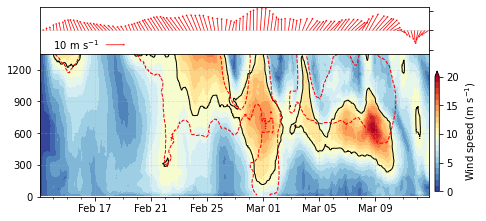

saving  /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_transect_beaufort_wrf10.png


In [13]:
# WSPEED ############################

gs = gridspec.GridSpec(4,1)
fig = plt.figure(figsize=(6,3))
ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1:4, 0]) # top: for wspeed

for n, ds in enumerate([ds10, ds80]):
    
    yvals, vtimes, transect = get_transect(ds['wspeed'] ,start_time, end_time, xpoint, ypoint)

    if n==1:
        cline = ax1.contour(vtimes, yvals, transect.transpose(), 
                            levels=[10],  colors='r', 
                            linestyles='--',linewidths=1)
    else:
        
        # plot avg winds along transect             
        ds_sel = ds.sel(x=xpoint[0], y=slice(ypoint[0], ypoint[1])).mean(dim=('y')).squeeze()
        plot_vectors(ax0, ds_sel)

        plot_transect(ax1, 'wspeed', add_insetmap=False)
    
    
ax0.yaxis.set_ticks_position("right")   #set y-axis on right
ax0.yaxis.set_label_position("right")

ax1.set_ylabel((''))
ax1.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.
ax1.grid(linestyle='--', alpha=0.3)

fig.subplots_adjust(bottom=0.1, top=0.98, left=0.0, right=0.9, wspace=0.08, hspace=0.0)
plt.show()

# save figure
figname = outpath_plots+'wspeed_transect_beaufort_wrf10' + '.png'
print("saving ", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')   

Start plotting icevel


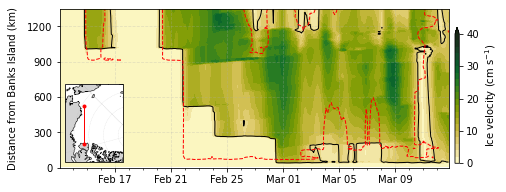

saving  /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/icevel_transect_beaufort_wrf10.png


In [14]:
# ICEVEL ############################
gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(6,2.5))
ax = fig.add_subplot(gs[0:3, 0])

for n, ds in enumerate([ds10, ds80]):
    
    yvals, vtimes, transect = get_transect(ds['icevel'] ,start_time, end_time, xpoint, ypoint)

    if n==1:
        cline = ax.contour(vtimes, yvals, transect.transpose(), 
                            levels=[10],  colors='r', 
                            linestyles='--',linewidths=1)
    else:
        plot_transect(ax, 'icevel', add_insetmap=True)  

ax.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.
ax.grid(linestyle='--', alpha=0.3)
ax.set_ylabel('Distance from Banks Island (km)', labelpad=10)

fig.subplots_adjust(bottom=0.1, top=0.98, left=0.0, right=0.9, wspace=0.08, hspace=0.0)
plt.show()

# save figure
figname = outpath_plots+'icevel_transect_beaufort_wrf10' + '.png'
print("saving ", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')   

In [15]:
# Load observations (OSISAF + Arcleads)

rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
obsdir = rootdir + 'home/rheinlender/data/'
outpath_plots =  rootdir + 'home/rheinlender/figs/breakup-paper/'

# OSISAF drift
obs_mod_drift = np.load(obsdir + 'wrf_arctic_10km_osisaf_nextsim_drift.npz', allow_pickle=True)
obs_siu = obs_mod_drift['obs_dx']
obs_siv = obs_mod_drift['obs_dy']
obs_date_vec = obs_mod_drift['obs_date_vec']
obs_icevel = np.hypot(obs_siu,obs_siv)

y_vec_km, trans = get_transect_osisaf(obs_icevel, 100, (180, 450)) 

# open Arcleads interpolated to nextsim grid
arc = xr.open_dataset(obsdir + 'Arcleads/Arcleads_interp2nextsim_20130212-20130313.nc')

yvals, arc_times, lead_trans = get_transect(arc['leadmap'],start_time, end_time, xpoint, ypoint)

# mask leads (leads=4)
leadmsk = xr.where(lead_trans==4, 1, np.nan)


(270,) (270, 25)


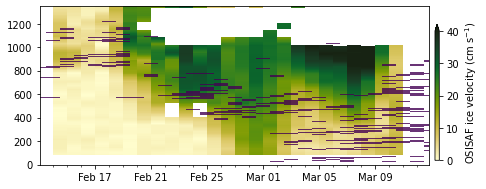

saving  /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/osisaf_drift_Arcleads_transect_beaufort.png


In [16]:
# OBS ############################

clabel, figname, cmap, clim, cb_extend, zlev = _PLOT_INFO['icevel']
clabel = 'OSISAF ice velocity (cm s$^{-1}$)'
clevs = np.arange(clim[0], clim[1]+clim[2], clim[2])

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(6,2.5))
ax = fig.add_subplot(gs[0:3, 0])

# OSISAF drift
im = ax.pcolormesh(obs_date_vec, y_vec_km, trans, cmap=cmocean.cm.speed, vmin=clim[0],vmax=clim[1], shading='nearest')
#cline = ax.contour(obs_date_vec, y_vec_km, trans,  
#                            levels=[5],  colors='k', 
#                           linestyles='-',linewidths=1)

# Arcleads
im2 = ax.pcolormesh(arc_times, yvals, leadmsk.transpose(),  shading='nearest', alpha=0.8)

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylabel((''))
ax.set_xbound(vtimes[0],vtimes[-1])

# add colorbar
pos = ax.get_position() 
cax = fig.add_axes([pos.xmax+.015, pos.y0, 0.01, pos.ymax-pos.y0 ])
cbar=fig.colorbar(im,cax=cax,extend='max')
cbar.set_label(clabel)
cbar.set_ticks(clevs[::5])
fig.subplots_adjust(bottom=0.1, top=0.98, left=0.0, right=0.9, wspace=0.08, hspace=0.0)
plt.show()
# save figure
figname = outpath_plots+'osisaf_drift_Arcleads_transect_beaufort' + '.png'
print("saving ", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')   

# Hovmoeller plot of categorical Arcleads 

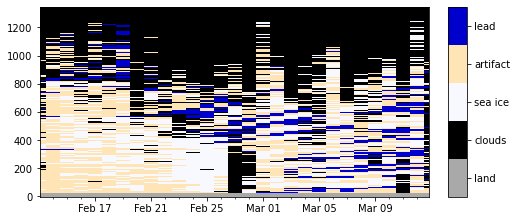

saving  /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/ArcLeads_transect_beaufort.png


In [17]:

yvals, arc_times, lead_trans = get_transect(arc['leadmap'],start_time, end_time, xpoint, ypoint)

# define colors
col_dict={0:"darkgrey",
          1:"black",
          2:"ghostwhite",
          3:"moccasin",
          4:"mediumblue"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# get colorbar tick labels 
#attr = ds.attrs['surface_classes']

labels={0:"land",
        1:"clouds",
        2:"sea ice",
        3:"artifact",
        4:"lead"}

# prepare normalizer
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.
norm_bins = np.insert(norm_bins, len_lab, np.max(norm_bins) + 1.0)

## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, len(labels), clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])



fig, ax = plt.subplots(1,1,figsize=(6,3)) 

im = ax.pcolormesh(arc_times, yvals, lead_trans.transpose(), shading='nearest', alpha=1, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cax = inset_axes(ax,
            width="5%",  # width = 50% of parent_bbox width
            height="100%",  # height : 5%
            loc='lower left',
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0)

cbar = plt.colorbar(im, cax=cax, format=fmt, ticks=tickz)


days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylabel((''))
ax.set_xbound(vtimes[0],vtimes[-1])


fig.subplots_adjust(bottom=0.1, top=0.98, left=0.0, right=0.9, wspace=0.08, hspace=0.0)
plt.show()

# save figure
figname = outpath_plots+'ArcLeads_transect_beaufort' + '.png'
print("saving ", figname)
fig.savefig(figname, dpi=300)   